In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def gaussian_sketch(d, n):
    return np.random.normal(0, np.sqrt(1/d), (d, n))

In [3]:
def count_sketch(d, n):
    sketch = np.zeros((d, n))
    """
    mappings: n-dimesional vector (j-th entry denotes which row-element is non-zero for the j-th column) 
    flips: denotes whether the non-zero element is 1 or -1
    """
    mappings = np.random.randint(0, d, size=(1, n))
    flips = np.random.choice([-1,1], size=(1, n))
    sketch[mappings, np.arange(n)] = flips
    return sketch

In [4]:
def visualize(fn, n=50, d=30, n_samples=50):
    # Sample generation
    sketch_matrices = [fn(d, n) for _ in range(n_samples)]
    sketch_matrices = np.stack(list(mtx.T.dot(mtx) for mtx in sketch_matrices), axis=2)
    expect_data = np.mean(sketch_matrices, axis=2)
    var_data = np.var(sketch_matrices, axis=2)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    fig.tight_layout()
    
    im1 = ax1.imshow(expect_data, cmap='YlGn')
    cbar1 = ax1.figure.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("Expectation", rotation=-90, va="bottom")
    
    im2 = ax2.imshow(var_data, cmap='YlGn')
    cbar2 = ax2.figure.colorbar(im2, ax=ax2)
    cbar2.ax.set_ylabel("Variance", rotation=-90, va="bottom")
    return

gaussian_sketch, count_sketch None None


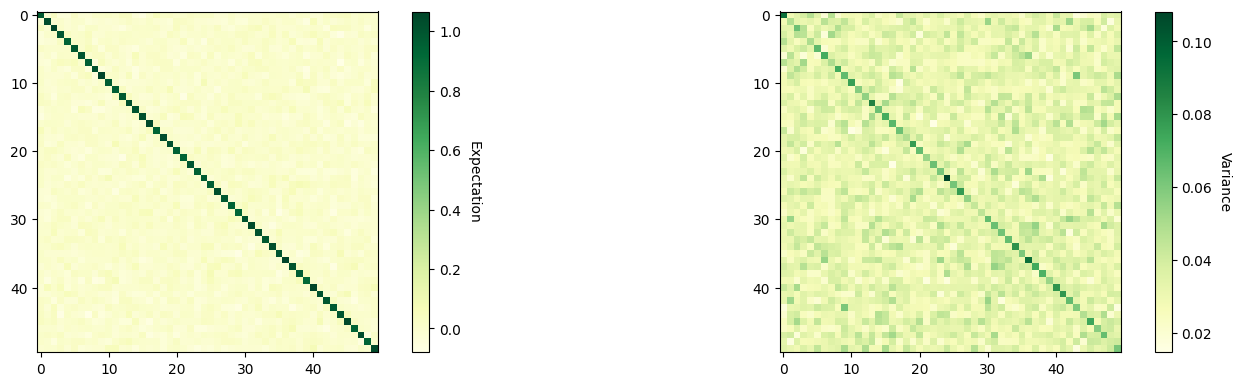

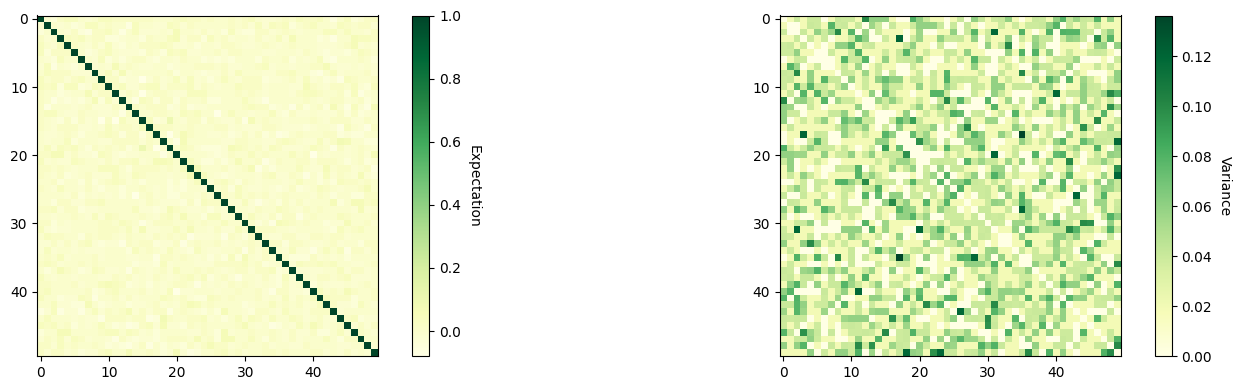

In [7]:
print('gaussian_sketch, count_sketch', visualize(gaussian_sketch), visualize(count_sketch))

Check accuracy using Matrix Multiplication

In [10]:
# Generate a random matrix A of size n x m
n = 15000
m = 1000
A = np.random.normal(50, 100, size = (n, m))

In [14]:
# Calculates Sketch of A, that is S*A, with sketch-dimension d
def calc_gauss_sketch(d, A):
    return gaussian_sketch(d, A.shape[0]).dot(A)
def calc_count_sketch(d, A):
    n, m = np.shape(A)
    C = np.zeros((d, m))
    mappings = np.random.randint(0, d, size=(1, n))
    flips = np.random.choice([-1, 1], size=(1, n))
    for i in range(n):
        C[mappings[0, i], :] += flips[0, i]*A[i, :]
    return C
# Calculate percentage error in Frobenius norm as defined above
def calc_error(exact_product, sketched_product):
    return 100*np.linalg.norm(exact_product - sketched_product, ord='fro')/np.linalg.norm(exact_product, ord='fro')

In [17]:
def generate_plots(A, num_samples = 10):
    """
    This function generates time and error plots for sketched matrix multiplication
    """
    n,m = A.shape
    sketch_dims = [int(m*x/4) for x in range(5,12,1)]
    print("Sketch dimensions considered")
    print(list(sketch_dims))
    
    a = len(sketch_dims)
    g_time = np.zeros(a)
    g_error = np.zeros(a)
    c_time = np.zeros(a)
    c_error = np.zeros(a)
    iter = 0
       
    ## Calculating exact product
    t1 = time.time()
    exact_product = (A.T).dot(A)
    t_exact = time.time() - t1
    
    for d in sketch_dims:
        ## Gaussian sketch
        for _ in range(num_samples):
            t2 = time.time()
            g_sketch = calc_gauss_sketch(d, A)
            g_product = g_sketch.T.dot(g_sketch)
            g_time[iter] += time.time() - t2
            g_error[iter] += calc_error(exact_product, g_product)

            ## Count sketch
            t3 = time.time()
            c_sketch = calc_count_sketch(d, A)
            c_product = c_sketch.T.dot(c_sketch)
            c_time[iter] += time.time() - t3
            c_error[iter] += calc_error(exact_product, c_product)
        iter += 1 
    
    ## Averaging error over all sample points
    g_time = g_time/num_samples
    g_error = g_error/num_samples
    c_time = c_time/num_samples
    c_error = c_error/num_samples
    
    fig, ax = plt.subplots(1,1,figsize=(12, 4))
    ax.plot(sketch_dims, g_error, label="Gaussian Sketch")
    ax.plot(sketch_dims, c_error, label="Count Sketch")

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.plot(sketch_dims, g_time, label="Gaussian Sketch")
    ax1.plot(sketch_dims, t_exact*np.ones(len(sketch_dims)), label="Exact multiplication")
    ax2.plot(sketch_dims, c_time, label="Count Sketch")
    ax2.plot(sketch_dims, t_exact*np.ones(len(sketch_dims)), label="Exact multiplication")


    ax.legend(loc="best")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    
    ax.set_xlabel("Sketch dimension (d)")
    ax1.set_xlabel("Sketch dimension (d)")
    ax2.set_xlabel("Sketch dimension (d)")

    ax.set_ylabel("Percentage Error")
    ax1.set_ylabel("Time to compute product (seconds)")
    ax2.set_ylabel("Time to compute product (seconds)")
    
    ax.set_ylim(bottom=0)
    ax.grid(True)
    ax.set_title("Error for Count and Gaussian sketches")
    

    ax1.set_ylim(bottom=0)
    ax1.grid(True)   
    ax1.set_title("Compute time for Gaussian-sketched Multiply")

    ax2.set_ylim(bottom=0, top=ax2.get_ylim()[1]*1.15)
    ax2.grid(True)   
    ax2.set_title("Compute time for Count-sketched Multiply")
    
    plt.show()

Sketch dimensions considered
[1250, 1500, 1750, 2000, 2250, 2500, 2750]


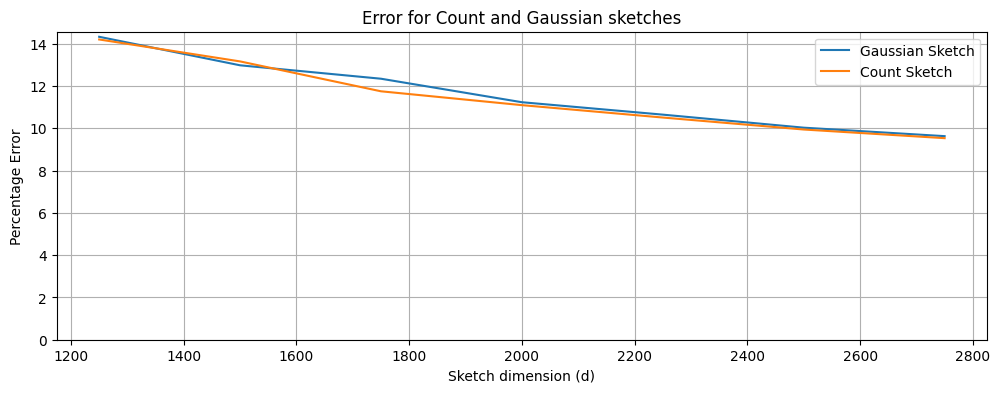

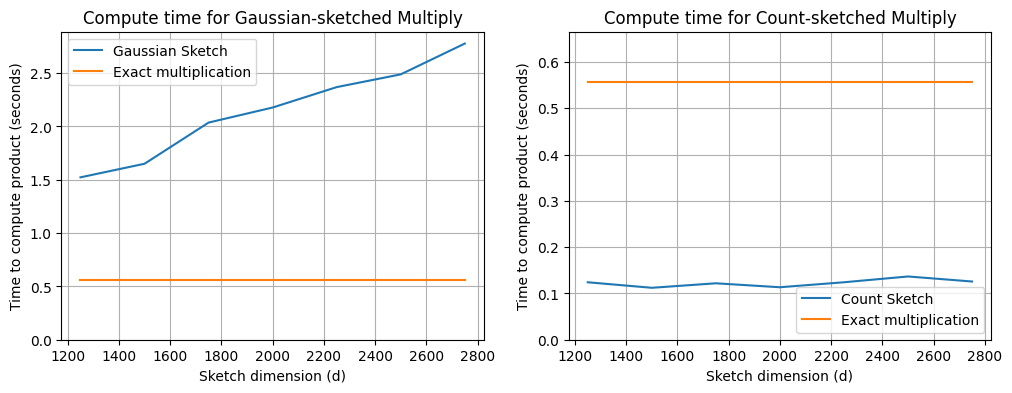

In [18]:
### This might take a few minutes to run, reduce n_samples to reduce running time (especially while debugging)
generate_plots(A)